In this notebook we evaluate the explainability of two models : KAN and Random Forest, on the dataset COMPAS for binary classification task. To do this, we'll be using two popular methods, SHAP and PFI.

In [ ]:
!pip install git+https://github.com/KindXiaoming/pykan.git #Importing the KAN code from github

  Cloning https://github.com/KindXiaoming/pykan.git to /tmp/pip-req-build-9p5eed1f
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-9p5eed1f
  Resolved https://github.com/KindXiaoming/pykan.git to commit d51e849bc7e95bc9733d4259e61192ba9bffa697
  Preparing metadata (setup.py) ... done
  Created wheel for pykan: filename=pykan-0.2.8-py3-none-any.whl size=78190 sha256=c69707caeef01d318c8f9b99786d5719e2f4ce546df85a9053ed94910d28aa0f
  Stored in directory: /tmp/pip-ephem-wheel-cache-dlc2_a_r/wheels/47/ca/5a/98124e020f3119f51c17f78738c621c140b7aa803b0feda76e
Successfully built pykan


Import Packages

In [ ]:
import torch
from kan import KAN

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.inspection import permutation_importance
import shap

Data Analysis and Cleaning

In [ ]:
df = pd.read_csv("/content/compas-scores-two-years.csv")

In [ ]:
df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


In [ ]:
categorical_columns = df.select_dtypes(include=['object']).columns
print("Categorical Columns:", categorical_columns)

Categorical Columns: Index(['name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age_cat', 'race', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_charge_degree', 'c_charge_desc',
       'r_case_number', 'r_charge_degree', 'r_offense_date', 'r_charge_desc',
       'r_jail_in', 'r_jail_out', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment', 'score_text',
       'screening_date', 'v_type_of_assessment', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody'],
      dtype='object')


In [ ]:
print(df.columns)

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')


In [ ]:
distinct_values = df['two_year_recid'].unique()
print("Distinct values in 'two_year_recid':", distinct_values)

Distinct values in 'two_year_recid': [0 1]


In [ ]:
# Drop unnecessary columns
columns_to_drop = [
    'id', 'name', 'first', 'dob', 'r_jail_in', 'r_jail_out', 'last', 'compas_screening_date', 'c_case_number', 'r_case_number',
    'vr_case_number', 'c_offense_date', 'r_offense_date', 'vr_offense_date', 'c_arrest_date',
    'vr_offense_date', 'screening_date', 'v_screening_date', 'decile_score.1',
    'score_text', 'v_score_text', 'priors_count.1', 'start', 'end', 'event', 'type_of_assessment', 'v_type_of_assessment',
    'in_custody', 'out_custody', 'c_jail_in', 'c_jail_out', 'c_jail_out'
]

df = df.drop(columns=columns_to_drop)


In [ ]:
df

,sex,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,...,is_recid,r_charge_degree,r_days_from_arrest,r_charge_desc,violent_recid,is_violent_recid,vr_charge_degree,vr_charge_desc,v_decile_score,two_year_recid
0,Male,69,Greater than 45,Other,0,1,0,0,0,-1.0,...,0,NaN,NaN,NaN,NaN,0,NaN,NaN,1,0
1,Male,34,25 - 45,African-American,0,3,0,0,0,-1.0,...,1,(F3),NaN,Felony Battery (Dom Strang),NaN,1,(F3),Felony Battery (Dom Strang),1,1
2,Male,24,Less than 25,African-American,0,4,0,1,4,-1.0,...,1,(M1),0.0,Driving Under The Influence,NaN,0,NaN,NaN,3,1
3,Male,23,Less than 25,African-American,0,8,1,0,1,NaN,...,0,NaN,NaN,NaN,NaN,0,NaN,NaN,6,0
4,Male,43,25 - 45,Other,0,1,0,0,2,NaN,...,0,NaN,NaN,NaN,NaN,0,NaN,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,Male,23,Less than 25,African-American,0,7,0,0,0,-1.0,...,0,NaN,NaN,NaN,NaN,0,NaN,NaN,5,0
7210,Male,23,Less than 25,African-American,0,3,0,0,0,-1.0,...,0,NaN,NaN,NaN,NaN,0,NaN,NaN,5,0
7211,Male,57,Greater than 45,Other,0,1,0,0,0,-1.0,...,0,NaN,NaN,NaN,NaN,0,NaN,NaN,1,0
7212,Female,33,25 - 45,African-American,0,2,0,0,3,-1.0,...,0,NaN,NaN,NaN,NaN,0,NaN,NaN,2,0


In [ ]:
print(df.columns)

Index(['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_days_from_compas', 'c_charge_degree',
       'c_charge_desc', 'is_recid', 'r_charge_degree', 'r_days_from_arrest',
       'r_charge_desc', 'violent_recid', 'is_violent_recid',
       'vr_charge_degree', 'vr_charge_desc', 'v_decile_score',
       'two_year_recid'],
      dtype='object')


In [ ]:
# Check for missing values
print("Missing values in each column:\n", df.isnull().sum())

Missing values in each column:
 sex                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest     307
c_days_from_compas           22
c_charge_degree               0
c_charge_desc                29
is_recid                      0
r_charge_degree            3743
r_days_from_arrest         4898
r_charge_desc              3801
violent_recid              7214
is_violent_recid              0
vr_charge_degree           6395
vr_charge_desc             6395
v_decile_score                0
two_year_recid                0
dtype: int64


In [ ]:
# Drop columns with high number of Nan values
columns_to_drop= ['days_b_screening_arrest', 'r_charge_degree', 'r_days_from_arrest',
       'r_charge_desc', 'violent_recid', 'vr_charge_degree', 'vr_charge_desc']
df = df.drop(columns=columns_to_drop)

In [ ]:
df.dropna(inplace=True)  # Drop rows with missing values

In [ ]:
df

,sex,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,is_violent_recid,v_decile_score,two_year_recid
0,Male,69,Greater than 45,Other,0,1,0,0,0,1.0,F,Aggravated Assault w/Firearm,0,0,1,0
1,Male,34,25 - 45,African-American,0,3,0,0,0,1.0,F,Felony Battery w/Prior Convict,1,1,1,1
2,Male,24,Less than 25,African-American,0,4,0,1,4,1.0,F,Possession of Cocaine,1,0,3,1
3,Male,23,Less than 25,African-American,0,8,1,0,1,1.0,F,Possession of Cannabis,0,0,6,0
4,Male,43,25 - 45,Other,0,1,0,0,2,76.0,F,arrest case no charge,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,Male,23,Less than 25,African-American,0,7,0,0,0,1.0,F,Deliver Cannabis,0,0,5,0
7210,Male,23,Less than 25,African-American,0,3,0,0,0,1.0,F,Leaving the Scene of Accident,0,0,5,0
7211,Male,57,Greater than 45,Other,0,1,0,0,0,1.0,F,Aggravated Battery / Pregnant,0,0,1,0
7212,Female,33,25 - 45,African-American,0,2,0,0,3,1.0,M,Battery on Law Enforc Officer,0,0,2,0


In [ ]:
# One-hot encoding categorical columns 1/0
columns_encode = ['sex']
encoded_data = pd.get_dummies(df[columns_encode], prefix=columns_encode, drop_first=True)
encoded_data = encoded_data.astype(int)

# Concatenate the one-hot encoded columns with the original DataFrame
df.drop(columns_encode, axis=1, inplace=True)
df = pd.concat([df, encoded_data], axis=1)

In [ ]:
# Encoding categorical features
categorical_cols = ['age_cat', 'race', 'c_charge_desc', 'c_charge_degree']

# Label Encoding for categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [ ]:
df

,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,is_violent_recid,v_decile_score,two_year_recid,sex_Male
0,69,1,5,0,1,0,0,0,1.0,0,17,0,0,1,0,1
1,34,0,0,0,3,0,0,0,1.0,0,172,1,1,1,1,1
2,24,2,0,0,4,0,1,4,1.0,0,318,1,0,3,1,1
3,23,2,0,0,8,1,0,1,1.0,0,317,0,0,6,0,1
4,43,0,5,0,1,0,0,2,76.0,0,436,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,23,2,0,0,7,0,0,0,1.0,0,123,0,0,5,0,1
7210,23,2,0,0,3,0,0,0,1.0,0,213,0,0,5,0,1
7211,57,1,5,0,1,0,0,0,1.0,0,21,0,0,1,0,1
7212,33,0,0,0,2,0,0,3,1.0,1,50,0,0,2,0,0


In [ ]:
# Prepare input features and labels
X = df.drop('two_year_recid', axis=1)
y = df['two_year_recid']

# Ensure X and y do not contain NaNs
X.dropna(inplace=True)
y.dropna(inplace=True)
y = y[X.index]  # Align y with the remaining X

In [ ]:
# Splitting the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

In [ ]:
print(X_train.shape)

(5029, 15)


In [ ]:
# Drop NaNs in X_train, X_val, and X_test
X_train.dropna(inplace=True)
X_val.dropna(inplace=True)
X_test.dropna(inplace=True)

y_train.dropna(inplace=True)
y_val.dropna(inplace=True)
y_test.dropna(inplace=True)

In [ ]:
# transforming the data
train_input = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
train_label = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1)
val_input = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
val_label = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)
test_input = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
test_label = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

In [ ]:
# creating the dataset
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'val_input': val_input,
    'val_label': val_label,
    'test_input': test_input,
    'test_label': test_label
}

Random Forest Model

In [ ]:
# the best model from GridSearchCV
rf_model = RandomForestClassifier(
    max_depth=8,
    max_samples=0.8,
    min_samples_leaf=3,
    n_estimators=80,
    random_state=1
)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Make predictions
train_preds_rf = rf_model.predict(X_train)
val_preds_rf = rf_model.predict(X_val)
test_preds_rf = rf_model.predict(X_test)


In [ ]:
#Evaluating the model
# Accuracy
print("Train Accuracy:", accuracy_score(y_train, train_preds_rf))
print("Validation Accuracy:", accuracy_score(y_val, val_preds_rf))
print("Test Accuracy:", accuracy_score(y_test, test_preds_rf))

# Precision, rappel, F1-score
print("Train Precision:", precision_score(y_train, train_preds_rf))
print("Train Recall:", recall_score(y_train, train_preds_rf))
print("Train F1-Score:", f1_score(y_train, train_preds_rf))

Train Accuracy: 0.9709683833764168
Validation Accuracy: 0.9666048237476809
Test Accuracy: 0.9684601113172542
Train Precision: 0.9391413088786995
Train Recall: 1.0
Train F1-Score: 0.968615649183147


Ordered Feature Importance (PFI):
               Feature  Importance   Std Dev
11            is_recid    0.459184  0.009614
12    is_violent_recid    0.000093  0.000278
0                  age    0.000000  0.000000
1              age_cat    0.000000  0.000000
2                 race    0.000000  0.000000
3        juv_fel_count    0.000000  0.000000
4         decile_score    0.000000  0.000000
5       juv_misd_count    0.000000  0.000000
6      juv_other_count    0.000000  0.000000
7         priors_count    0.000000  0.000000
8   c_days_from_compas    0.000000  0.000000
9      c_charge_degree    0.000000  0.000000
10       c_charge_desc    0.000000  0.000000
13      v_decile_score    0.000000  0.000000
14            sex_Male    0.000000  0.000000


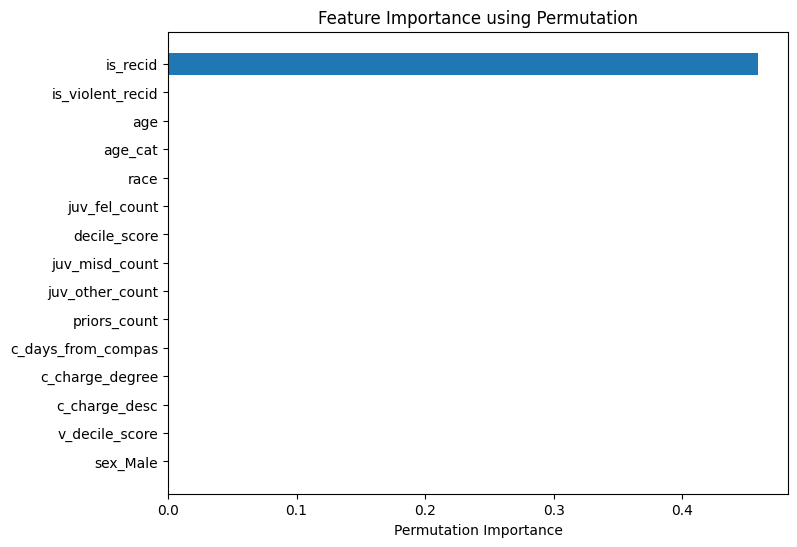

In [ ]:
# Calculate Permutation Feature Importance (PFI)
pfi_result = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Create a DataFrame to store the importance results
pfi_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': pfi_result.importances_mean,
    'Std Dev': pfi_result.importances_std
})

# Sort the features by importance
pfi_importances_sorted = pfi_importances.sort_values(by='Importance', ascending=False)

# Display the ordered feature importances
print("Ordered Feature Importance (PFI):")
print(pfi_importances_sorted)

# Plot the feature importance in descending order
plt.figure(figsize=(8, 6))
plt.barh(pfi_importances_sorted['Feature'], pfi_importances_sorted['Importance'])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance using Permutation")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

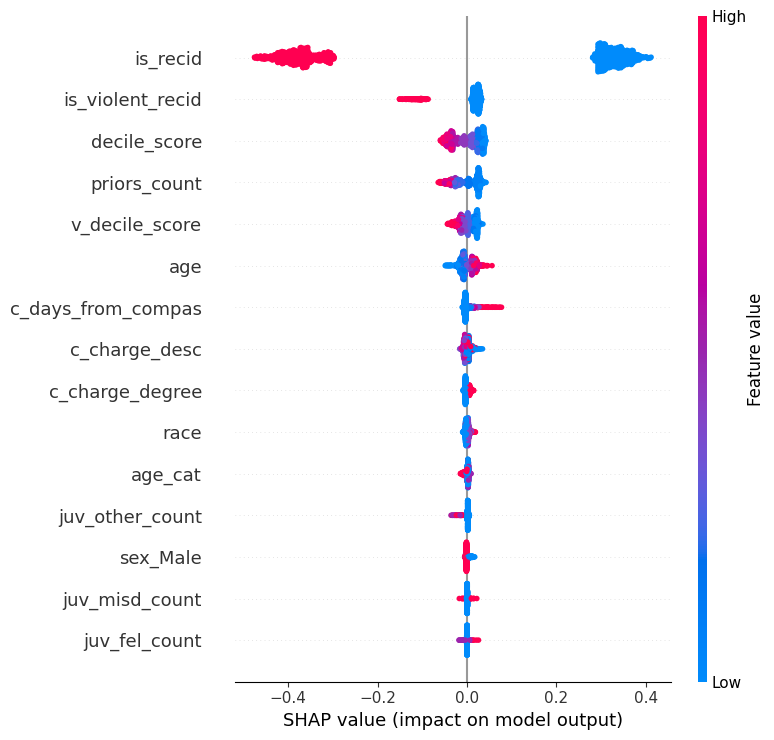

In [ ]:
# Initialize SHAP explainer for the Random Forest model
X_test_sample = X_test.sample(n=1000, random_state=42)
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for the test set
shap_values_rf = explainer(X_test_sample)
shap.summary_plot(shap_values_rf[:,:,0], X_test_sample)

# Calculate the mean absolute SHAP value for each feature across all samples for class 0
shap_importances = pd.DataFrame({
    'Feature': X_test_sample.columns,
    'Importance': np.mean(np.abs(shap_values_rf[:,:,0].values), axis=0) # Calculate mean absolute SHAP value for each feature
})
shap_importances_sorted = shap_importances.sort_values(by='Importance', ascending=False)

Agreement metric for RF

In [ ]:
# Function to measure greement for the top k features using Jaccard Index
def agreement_metric(top_k_shap, top_k_pfi):
    set_shap = set(top_k_shap)
    set_pfi = set(top_k_pfi)

    intersection = len(set_shap.intersection(set_pfi))
    union = len(set_shap.union(set_pfi))

    score = intersection / union if union != 0 else 0
    return score

# Define k the number of top features to compare
k = 4

# Extract top k features
top_k_shap = shap_importances_sorted['Feature'][:k]
top_k_pfi = pfi_importances_sorted['Feature'][:k]

score = agreement_metric(top_k_shap, top_k_pfi)
print(f"Agreement metric for the top {k} features using Random Forest: {score:.4f}")


Agreement metric for the top 4 features using Random Forest: 0.3333


KAN Model

In [ ]:
# Create the KAN model
model = KAN(width=[15, 8, 1], grid=5, k=3, seed=0)  # one hidden layer with 10 neurons

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
results = model.fit(
    {'train_input': train_input, 'train_label': train_label, 'test_input': val_input, 'test_label': val_label},
    opt="LBFGS", steps=50, loss_fn=torch.nn.BCEWithLogitsLoss() #Binary crossentropy loss
)

| train_loss: 3.65e-01 | test_loss: 4.09e-01 | reg: 1.42e+02 | : 100%|█| 50/50 [01:49<00:00,  2.18s/

saving model version 0.1


In [ ]:

# Predictions of train, val, and test datasets
test_preds = model.forward(test_input).detach()
train_preds = model.forward(train_input).detach()
val_preds = model.forward(val_input).detach()

# Sigmoid to get probabilities
test_probs = torch.sigmoid(test_preds)
train_probs = torch.sigmoid(train_preds)
val_probs = torch.sigmoid(val_preds)

# Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
test_preds_binary = (test_probs >= 0.5).int()
train_preds_binary = (train_probs >= 0.5).int()
val_preds_binary = (val_probs >= 0.5).int()

# Evaluate metrics for training data
train_labels = train_label.numpy()
train_preds_binary = train_preds_binary.numpy()
val_labels = val_label.numpy()
val_preds_binary = val_preds_binary.numpy()
test_labels = test_label.numpy()
test_preds_binary = test_preds_binary.numpy()

print("Train Accuracy:", accuracy_score(train_labels, train_preds_binary))
print("Train Precision:", precision_score(train_labels, train_preds_binary))
print("Val Accuracy:", accuracy_score(val_labels, val_preds_binary))
print("Val Precision:", precision_score(val_labels, val_preds_binary))
print("Test Accuracy:", accuracy_score(test_labels, test_preds_binary))
print("Test Precision:", precision_score(test_labels, test_preds_binary))



Train Accuracy: 0.9568502684430304
Train Precision: 0.9387931034482758
Val Accuracy: 0.9434137291280148
Val Precision: 0.9377510040160643
Test Accuracy: 0.9489795918367347
Test Precision: 0.9352226720647774


PFI KAN

              Features   Importances
11            is_recid  4.315770e-01
8   c_days_from_compas  1.109462e-02
10       c_charge_desc  2.235622e-03
0                  age  3.330669e-16
1              age_cat  3.330669e-16
2                 race  3.330669e-16
3        juv_fel_count  3.330669e-16
5       juv_misd_count  3.330669e-16
6      juv_other_count  3.330669e-16
9      c_charge_degree  3.330669e-16
12    is_violent_recid  3.330669e-16
14            sex_Male  3.330669e-16
7         priors_count -1.110223e-16
4         decile_score -1.484230e-04
13      v_decile_score -1.762523e-04


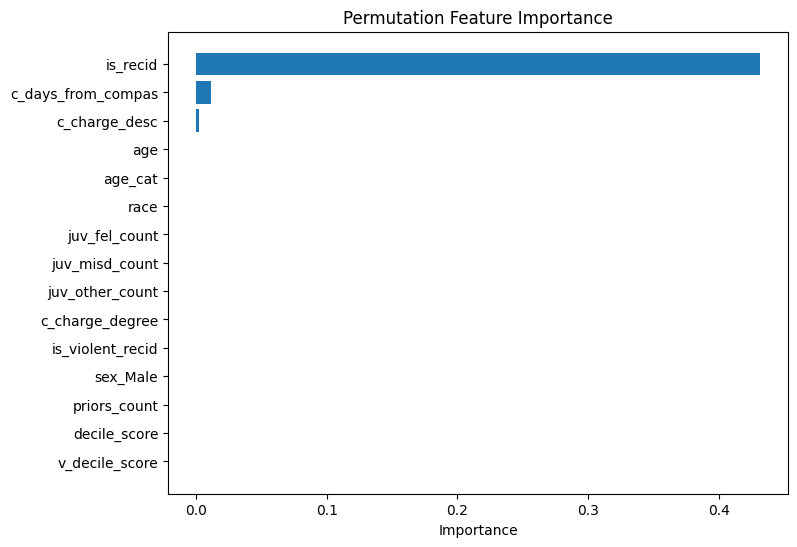

In [ ]:

# Function to evaluate model performance using accuracy
def evaluate_model(model, X, y):
    model.eval()
    with torch.no_grad():
        logits = model(torch.tensor(X, dtype=torch.float32))
        probs = torch.sigmoid(logits).numpy()
        predictions = (probs >= 0.5).astype(int)
    return accuracy_score(y, predictions)

# Function to calculate permutation feature importance (PFI)
def permutation_importance(model, X, y, metric=evaluate_model, n_repeats=100):
    baseline_score = metric(model, X, y)
    importances = np.zeros(X.shape[1])

    for i in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            np.random.shuffle(X_permuted[:, i])
            score = metric(model, X_permuted, y)
            scores.append(score)
        importances[i] = baseline_score - np.mean(scores)

    return importances


# Convert validation data to numpy arrays
X_val_tensor = X_val.to_numpy()
y_val_tensor = y_val.to_numpy()

# Calculate feature importances
importances_kan = permutation_importance(model, X_val_tensor, y_val_tensor)

# Create DataFrame with feature importances
importance_df = pd.DataFrame({
    'Features': X_val.columns,
    'Importances': importances_kan
}).sort_values(by='Importances', ascending=False)

print(importance_df)

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.barh(importance_df['Features'], importance_df['Importances'])
plt.xlabel('Importance')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()


SHAP for KAN

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
/usr/local/lib/python3.10/dist-packages/kan/MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  output_range_spline = torch.std(postacts_numerical, dim

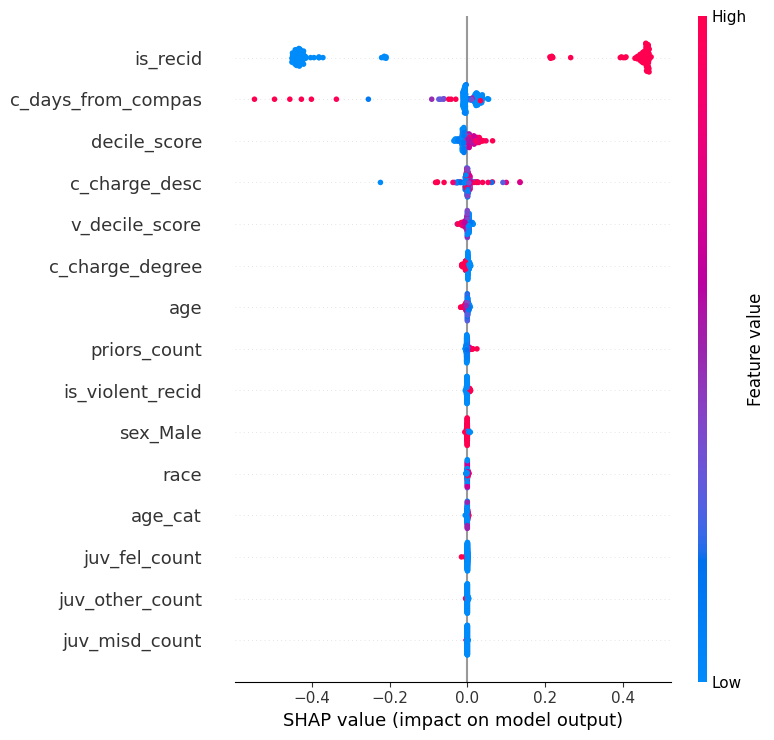

In [ ]:
# Define a prediction function that returns probabilities
def predict(data):
    data_tensor = torch.tensor(data, dtype=torch.float32)
    with torch.no_grad():
        # Get logits from the model and apply sigmoid to get probabilities
        logits = model(data_tensor)
        probs = torch.sigmoid(logits).numpy()
    return probs

# Sampling data
X_train_subset = X_train.sample(200, random_state=42).to_numpy()
X_test_subset = X_test.sample(200, random_state=42).to_numpy()

# Initialize the SHAP KernelExplainer
explainer = shap.KernelExplainer(predict, X_train_subset)

# Compute SHAP values for the test set subset
shap_values = explainer.shap_values(X_test_subset)

if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Select the SHAP values for class 1 (positive class)

# Plot the SHAP summary plot to visualize feature importance
shap_values = np.squeeze(shap_values)

# Convert the SHAP values into a DataFrame
shap_df_kan = pd.DataFrame(shap_values, columns=X_test.columns)

shap.summary_plot(shap_values, X_test_subset, feature_names=X_test.columns)


Agreement metric

In [ ]:
# Calculate the absolute SHAP values to evaluate feature importance
shap_abs_values = np.abs(shap_values)
# Define k the number of top features to compare
k = 4

# Calculate the mean absolute SHAP values for each feature
feature_importances = np.mean(shap_abs_values, axis=0)
top_k_indices = np.argsort(feature_importances)[-k:]

In [ ]:
# Extract top k features
top_k_shap = X_test.columns[top_k_indices]
top_k_pfi = importance_df['Features'][:k]

score_kan = agreement_metric(top_k_shap, top_k_pfi)
print(f"Agreement metric for the top {k} features using Random Forest: {score_kan:.4f}")

Agreement metric for the top 4 features using Random Forest: 0.6000
